In [1]:
import copy

import numpy as np
import scipy
from scipy import stats
import tensorflow.keras as keras
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Reshape, Flatten, LeakyReLU, Activation, Dense, BatchNormalization

import pygmo as pg

from IPython.display import clear_output
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def generator():
    model = Sequential()
    model.add(Dense(32,input_dim=1))
    model.add(LeakyReLU(0.2))
    model.add(Dense(32))
    model.add(LeakyReLU(0.2))
    model.add(Dense(1))
    model.add(LeakyReLU(0.2))
    return model

In [3]:
def discriminator(sample, mu, sigma):
    """
    Пока проверка на нормальность
    
    sample: list - выборка полученная от генератора
    mu: float - среднее распределения
    sigma: float - среднее квадратичное отклонение распределения
    """
    pvalue = stats.ttest_ind(sample,np.random.normal(loc=mu,scale=sigma,size=1000))[1]
    return 0.4 * (np.mean(sample) - mu)**2 + 0.4*(np.std(sample) - sigma)**2 - 0.2*pvalue
    # return np.mean(sample) - mu, np.std(sample) - sigma, -pvalue

In [4]:
generator = generator()

In [5]:
generator.summary() # 1153 параметра

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1)                 0         
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [6]:
class Problem:
    def __init__(self, fit_func, dim=407050, lb=-1., rb=1.):
        self.dim = dim
        self.lb = lb
        self.rb = rb
        self.fit_func = fit_func
        
    def fitness(self, weights):
        return self.fit_func(weights)

    def get_bounds(self):
        return (np.full((self.dim,), self.lb), np.full((self.dim,), self.rb))

In [7]:
SAMPLE_SIZE = 1000
REAL_MEAN = 5.0
REAL_STD = 2.0

In [8]:
def fit_func(weights):
    # Раскидывает веса
    weight_layer_one = np.array(weights[:32]).reshape(1,32)
    weight_layer_two = np.array(weights[32:64]).reshape(32,)
    weight_layer_three = np.array(weights[64:-65]).reshape(32,32)
    weight_layer_four = np.array(weights[-65:-33]).reshape(32,)
    weight_layer_five = np.array(weights[-33:-1]).reshape(32,1)
    weight_layer_six = np.array(weights[-1:]).reshape(1,)

    generator.set_weights([
        weight_layer_one,
        weight_layer_two,
        weight_layer_three,
        weight_layer_four,
        weight_layer_five,
        weight_layer_six
    ])
    
    #
    sample = generator.predict(np.random.random(SAMPLE_SIZE))
    return discriminator(sample, REAL_MEAN,REAL_STD)

In [9]:
my_prob = Problem(fit_func=fit_func, dim=1153, lb=-1., rb=1.)

In [10]:
algo = pg.algorithm(pg.sga(gen = 1000))

In [11]:
pop = pg.population(my_prob, 20)

In [12]:
pop = algo.evolve(pop)

In [13]:
pop.champion_f

array([-0.19928848])

In [14]:
weights = pop.champion_x

In [15]:
weight_layer_one = np.array(weights[:32]).reshape(1,32)
weight_layer_two = np.array(weights[32:64]).reshape(32,)
weight_layer_three = np.array(weights[64:-65]).reshape(32,32)
weight_layer_four = np.array(weights[-65:-33]).reshape(32,)
weight_layer_five = np.array(weights[-33:-1]).reshape(32,1)
weight_layer_six = np.array(weights[-1:]).reshape(1,)

generator.set_weights([
        weight_layer_one,
        weight_layer_two,
        weight_layer_three,
        weight_layer_four,
        weight_layer_five,
        weight_layer_six
    ])

In [16]:
y = generator.predict(np.random.random(size=10000))

(array([ 5., 13., 10., 13.,  8., 12., 17., 19., 11., 18., 13., 17., 10.,
        11., 20., 10., 13., 18., 23., 19., 14., 18., 21., 12., 12., 13.,
        15.,  6., 21., 20.,  7., 13., 19., 10., 15., 12., 11., 15.,  4.,
        13., 15., 12., 15.,  8.,  9., 23., 13., 10., 17., 12., 13., 10.,
        13., 13., 12., 10., 12., 18., 12., 17., 15.,  9., 15., 10., 13.,
        14., 14.,  8., 11., 10.,  7., 15., 18., 15., 11., 12., 15., 11.,
        13., 14., 11., 16.,  8., 16.,  9.,  7., 11.,  9., 11.,  9., 11.,
        13., 10., 13., 25., 12., 13., 14., 11., 15., 15., 16.,  7., 12.,
        12.,  9.,  7., 14., 14.,  9., 11., 15., 12., 15., 15.,  9., 14.,
        11., 18., 13., 11., 14., 11.,  9.,  9., 13., 11., 11.,  7., 12.,
        14., 12., 14., 12.,  7., 10.,  9.,  9., 17., 18., 17., 15., 13.,
        14., 23., 19., 13., 16.,  9., 27., 14., 14., 24., 14., 12., 16.,
        11.,  9., 14.,  8., 11., 17., 15., 21., 12., 16., 14.,  7., 14.,
        12., 12.,  7., 19., 18., 11., 12., 11.,  7.

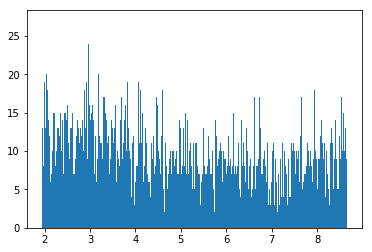

In [24]:
plt.hist(y,bins=1000)

In [18]:
stats.shapiro(generator.predict(np.random.random(100))) 
# Тест на нормальность в принципе. При втором числе меньшк .01 или 0.05 можно не думать о том, что выборка из номарльного 

(0.9382858276367188, 0.00015177621389739215)

In [19]:
stats.shapiro(np.random.normal(loc=10,scale=2,size=100))

(0.9826411008834839, 0.21230487525463104)

In [20]:
data = np.random.normal(loc=10,scale=2,size=100)
normaled_data = (data - .0)/1.0
stats.kstest(normaled_data,'norm')

KstestResult(statistic=0.9999999955332202, pvalue=0.0)

In [21]:
# Кажется надежнее просто смотреть на среднее и отклонение
stats.ttest_ind(np.random.normal(loc=10,scale=2,size=100),np.random.normal(loc=10,scale=2,size=1000))

Ttest_indResult(statistic=0.4819017486673065, pvalue=0.6299717810516865)

In [22]:
sample = [.111,1.3344,.434,.543]

In [23]:
np.std(sample)

0.44976213713473034